<a href="https://colab.research.google.com/github/PhillipMas/PhillipMas/blob/main/Tune_RNN_VaR_window_Exceedances_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 37s 255ms/step - loss: 1.0272
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 204ms/step - loss: 0.9937
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - loss: 1.0212
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - loss: 0.9709
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - loss: 0.9215
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - loss: 0.9663
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - loss: 0.9783
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - loss: 1.0102
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - loss: 0.9706
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - loss: 0.9988
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - loss: 1.0024
Epoch 12/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 42s 229ms/step - loss: 0.9777
Epoch 13/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - loss: 1.0380
Epoch 14/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - loss: 1.1663
Epoch 15/100
95/95 ━━━━━━━━━━

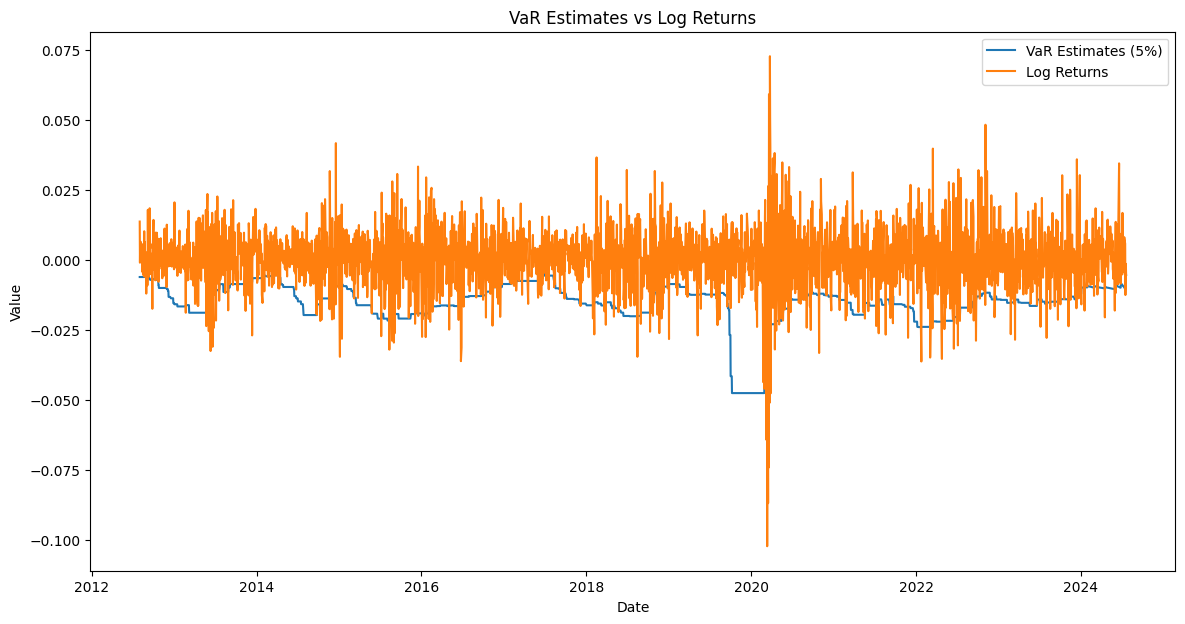

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Fetch data
ticker = '^J203.JO'  # Example ticker
data = yf.download(ticker, start='2012-01-01', end='2024-07-21')
data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
data = data.dropna()  # Drop NaN values

# Prepare data for LSTM
window_size = 120
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data['Log Returns'].values.reshape(-1, 1))

# Function to create rolling windows
def create_rolling_windows(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create rolling windows
X, y = create_rolling_windows(scaled_data, window_size)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=100))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=100, batch_size=32)

# Predict returns for each rolling window
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Calculate VaR for each rolling window
VaR_estimates = []
for i in range(window_size, len(data)):
    window_predictions = predictions[i-window_size:i]
    VaR = np.percentile(window_predictions, 5)  # 5% VaR
    VaR_estimates.append(VaR)

# Plot VaR estimates vs returns
plt.figure(figsize=(14, 7))
plt.plot(data.index[window_size:], VaR_estimates, label='VaR Estimates (5%)')
plt.plot(data.index[window_size:], data['Log Returns'].values[window_size:], label='Log Returns')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('VaR Estimates vs Log Returns')
plt.legend()
plt.show()


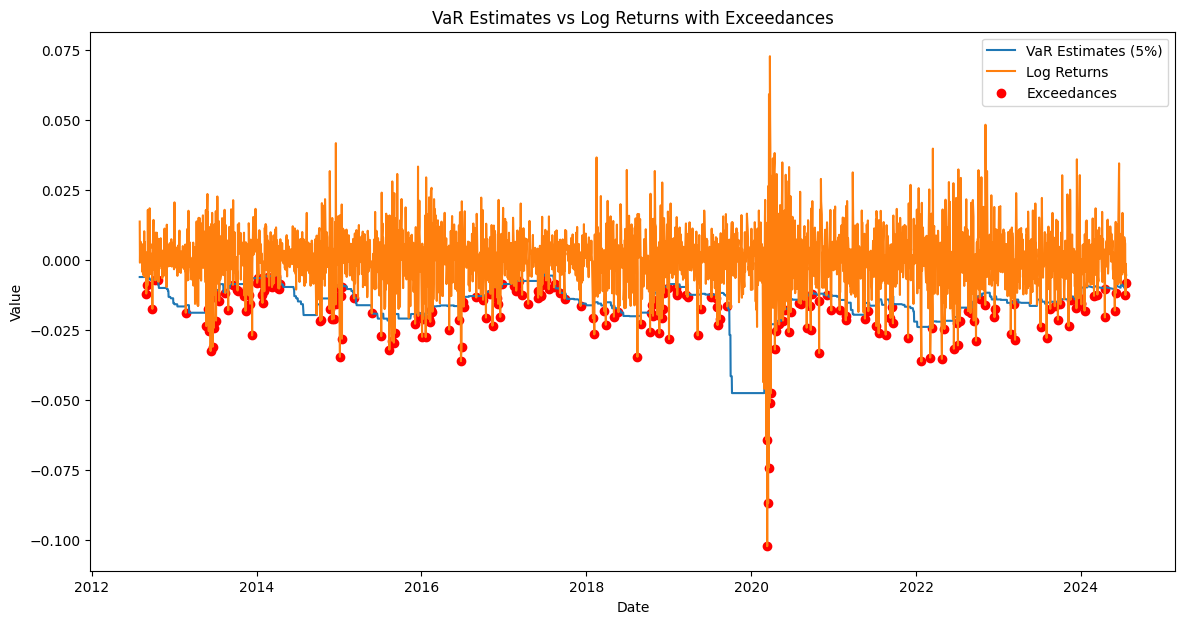

In [12]:
VaR_estimates = []
exceedances = []
for i in range(window_size, len(data)):
    window_predictions = predictions[i-window_size:i]
    VaR = np.percentile(window_predictions, 5)  # 5% VaR
    VaR_estimates.append(VaR)
    if data['Log Returns'].values[i] < VaR:
        exceedances.append(data.index[i])

# Plot VaR estimates vs returns with exceedances
plt.figure(figsize=(14, 7))
plt.plot(data.index[window_size:], VaR_estimates, label='VaR Estimates (5%)')
plt.plot(data.index[window_size:], data['Log Returns'].values[window_size:], label='Log Returns')
plt.scatter(exceedances, data.loc[exceedances]['Log Returns'], color='red', label='Exceedances')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('VaR Estimates vs Log Returns with Exceedances')
plt.legend()
plt.show()



In [26]:
exceedances = data['Log Returns'].values[window_size:] < VaR_estimates
failure_rate = np.mean(exceedances)

print(f"Total Exceedances: {sum(exceedances):.0f}")
print(f"total returns: {len(exceedances):.0f}")
print(f"Failure Rate: {failure_rate * 100:.2f}%")


Total Exceedances: 225
total returns: 3009
Failure Rate: 7.48%
